<a href="https://colab.research.google.com/github/mritogether/ESMRMB2024_Hardware_to_Map/blob/main/02_sequence_design_for_mapping/notebooks/s20_optimized_3d_mse_portableScanner_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From single-echo 3D SE to multi-echo 3D SE for T2 mapping on the portable scanner (solution)
Now let's extend the single-echo 3D SE to multi-echo 3D SE for T2 mapping.      

**Exercise**           
If you have no clue, search "hint" for hints.
1. Could you please implement four spin-echoes for the 3D SE sequence?

In [3]:
#@title 3D MSE for the portable scanner - environment setup (just need to run it once)
!pip show pypulseq || pip install pypulseq &> /dev/null
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as pp
# for simulation
!pip show MRzeroCore || pip install MRzeroCore
import MRzeroCore as mr0
import torch
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

Name: pypulseq
Version: 1.4.2
Summary: Pulseq in Python
Home-page: https://github.com/imr-framework/pypulseq
Author: Keerthi Sravan Ravi
Author-email: ks3621@columbia.edu
License: License :: OSI Approved :: GNU Affero General Public License v3
Location: /usr/local/lib/python3.10/dist-packages
Requires: coverage, matplotlib, numpy, scipy, sigpy
Required-by: MRzeroCore
Name: MRzeroCore
Version: 0.3.5
Summary: Core functionality of MRzero
Home-page: 
Author: 
Author-email: Jonathan Endres <jonathan.endres@uk-erlangen.de>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, pydisseqt, pypulseq, requests, scikit-image, scipy, torch, torchkbnufft
Required-by: 


TR fill: 277.52000000000004 ms
Timing check passed successfully


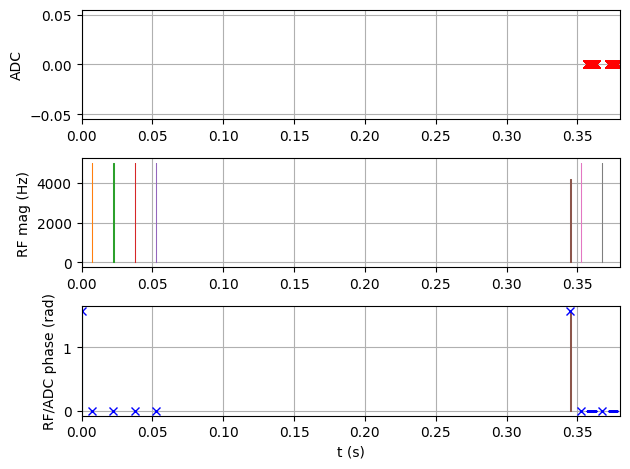

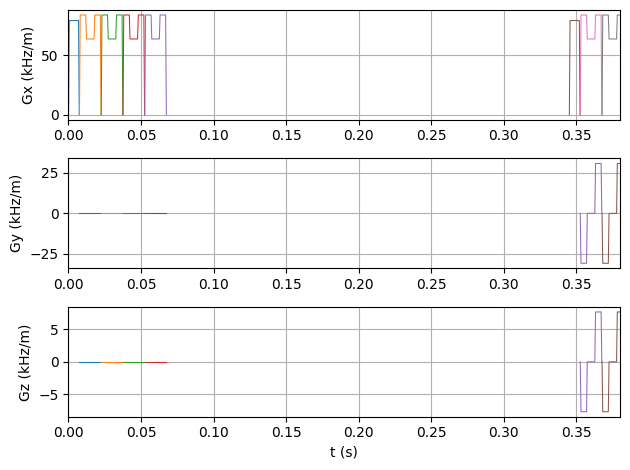

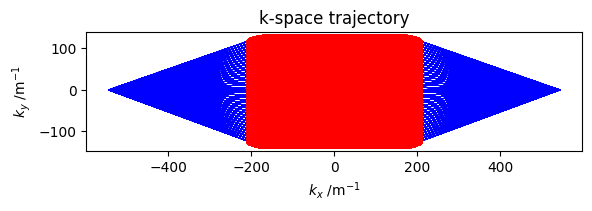

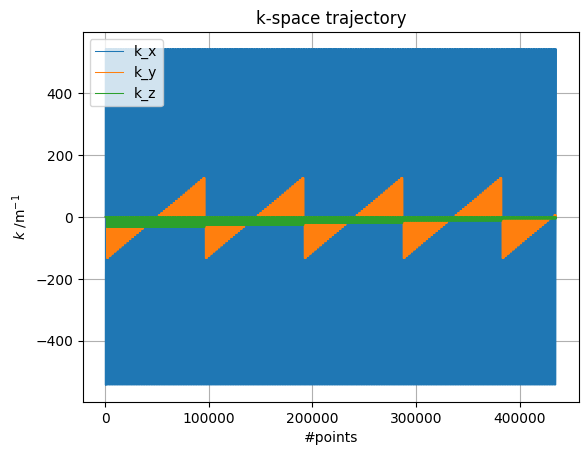

In [4]:
#@title 3D MSE for the portable scanner - sequence
experiment_id = 's20_3d_mse_portable_scanner'
def main(plot: bool, write_seq: bool, seq_filename: str = experiment_id):
    global rdGradTime
    global nRD_pre
    global nRD_post
    global nRD
    global nPH
    global n3D
    global n_echo
    global os
    # %% SETUP system
    # choose the scanner limits
    system = pp.Opts(
            max_grad=25,       # the portable scanner's limits are 25, 40 and 35 mT/m for X, Y and Z axes
            grad_unit="mT/m",
            max_slew=50,       # the portable scanner's limits are 50, 80 and 70 mT/m/ms for X, Y and Z, respectively
            slew_unit="T/m/s",
            rf_ringdown_time=15e-6,
            rf_dead_time=15e-6,
            adc_dead_time=0e-6 )
    # Create a new sequence object
    seq = pp.Sequence(system)

    # %% DEFINE the sequence, FOV, resolution, and other parameters
    fov_mm = (150, 150, 150) # Define FOV in [mm]
    nRD, nPH, n3D = [40, 40, 10]     # Define resolution (matrix sizes)
    TE = 15e-3 # Echo time of the first spin echo, same as the echo spacing (ESP) for the MSE train
    TR = 300e-3  # Repetition time

    rdGradTime = 5.2e-3 # unit: [s]
    acqTime = 4.2e-3 # unit: [s]
    dG = 500e-6 # ramping time for all gradients
    sampling_time = acqTime # desired useful sampling time
    rd_flattop_add = (rdGradTime - acqTime) / 2 # additional buffer areas on the flat top of the read gradient before and after the 'sampling_time'
    t_ex  = 60e-6 # [s], duration of the excitation pulse. needs to be of the same "parity" as the t_ref (fixme?), e.g. the half of t_ex should still be divisible by the gradient raster time
    t_ref = 100e-6 # [s], duration of the refocusing pulse
    fsp_r = 1 # spoiler area in the read direction in parts of the read gradient area
    rf_ex_phase = np.pi / 2 # phase of the excitation pulse
    rf_ref_phase = 0 # phase of the refocusing pulse
    nRD_pre = 10 # number of additional ADC samples to initialize decimation filters prior to the 'sampling_time'
    nRD_post = 10 # number of additional ADC samples needs for decimation filters after the 'sampling_time'
    os = 6 # oversmpling factor
    # hint: change n_echo from 1 to 4 to extend single-echo 3D SE to multi-echo 3D SE
    n_echo = 4 # number of echoes
    n_rd_points_per_train = n_echo * (nRD + nRD_pre + nRD_post) * os  # Number of points per echo train
    max_rd_points = 2 ** 18  # Maximum number of readout points per batch
    batches = {}  # Dictionary to save the batches with pypulseq sequences


    # derived and modifed parameters
    fov = np.array(fov_mm) * 1e-3 # FOV in meters
    TE = round(TE/system.grad_raster_time/2) * system.grad_raster_time * 2 # TE (=ESP) should be divisible to a double gradient raster, which simplifies calcuations
    rd_flattop_time = sampling_time + 2*rd_flattop_add ; # duration of the flat top of the read gradient
    rf_add = math.ceil(max(system.rf_dead_time,system.rf_ringdown_time)/system.grad_raster_time)*system.grad_raster_time # round up dead times to the gradient raster time to enable correct TE & ESP calculation
    t_sp = round((0.5 * (TE - rd_flattop_time - t_ref) - rf_add)/system.grad_raster_time)*system.grad_raster_time # the duration of gradient spoiler after the refocusing pulse
    t_spex = round((0.5 * (TE - t_ex - t_ref) - 2*rf_add)/system.grad_raster_time)*system.grad_raster_time # the duration of readout prephaser after the excitation pulse. note: exclude the RF ringdown time of excitation pulse and rf dead time of refocusing pulse

    # ======
    # CREATE EVENTS
    # ======
    # excitation and refocusing pulses
    flip_ex = 90 * np.pi / 180
    rf_ex = pp.make_block_pulse(
        flip_angle=flip_ex,
        system=system,
        duration=t_ex,
        delay=rf_add,
        phase_offset=rf_ex_phase )

    d_ex=pp.make_delay(t_ex+rf_add*2)

    flip_ref = 180 * np.pi / 180
    rf_ref = pp.make_block_pulse(
        flip_angle=flip_ref,
        system=system,
        duration=t_ref,
        delay=rf_add,
        phase_offset=rf_ref_phase,
        use="refocusing" )

    d_ref=pp.make_delay(t_ref+rf_add*2)

    delta_kx = 1 / fov[0]
    rd_amp = nRD * delta_kx / sampling_time

    gr_acq = pp.make_trapezoid(
        channel="x",
        system=system,
        amplitude = rd_amp,
        flat_time=rd_flattop_time,
        delay=t_sp,
        rise_time=dG )

    adc = pp.make_adc(
        num_samples=(nRD_pre+nRD+nRD_post)*os,
        dwell=sampling_time/nRD/os,
        delay=t_sp+rd_flattop_add-nRD_pre*sampling_time/nRD ) # nRD_pre*sampling_time/nRD: delay for additional ADC samples to initialize decimation filters prior to the 'sampling_time'

    gr_spr = pp.make_trapezoid(
        channel="x",
        system=system,
        area=gr_acq.area * fsp_r,
        duration=t_sp,
        rise_time=dG )

    # Phase-encoding
    delta_ky = 1 / fov[1]
    gp_max = pp.make_trapezoid(
                    channel="y",
                    system=system,
                    area=delta_ky*nPH/2,
                    duration=t_sp,
                    rise_time=dG )

    # Partition encoding
    delta_kz = 1 / fov[2]
    gs_max = pp.make_trapezoid(
                    channel="z",
                    system=system,
                    area=delta_kz*n3D/2,
                    duration=t_sp,
                    rise_time=dG )

    # combine parts of the read gradient
    gc_times = np.array(
        [
            0,
            gr_spr.rise_time,
            gr_spr.flat_time,
            gr_spr.fall_time,
            gr_acq.flat_time,
            gr_spr.fall_time,
            gr_spr.flat_time,
            gr_spr.rise_time ] )
    gc_times = np.cumsum(gc_times)

    gr_amp = np.array([0, gr_spr.amplitude, gr_spr.amplitude, gr_acq.amplitude, gr_acq.amplitude, gr_spr.amplitude, gr_spr.amplitude, 0])
    gr = pp.make_extended_trapezoid(channel="x", times=gc_times, amplitudes=gr_amp)

    agr_preph = gr.area / 2 # readout prephaser: account for readout pre-spoiler and readout gradient
    gr_preph = pp.make_trapezoid(
        channel="x", system=system, area=agr_preph, duration=t_spex, rise_time=dG )

    gp_amp = np.array([0, gp_max.amplitude, gp_max.amplitude, 0, 0, -gp_max.amplitude, -gp_max.amplitude, 0])
    gp_max = pp.make_extended_trapezoid(channel="y", times=gc_times, amplitudes=gp_amp)

    gs_amp = np.array([0, gs_max.amplitude, gs_max.amplitude, 0, 0, -gs_max.amplitude, -gs_max.amplitude, 0])
    gs_max = pp.make_extended_trapezoid(channel="z", times=gc_times, amplitudes=gs_amp)

    # Fill-times
    t_ex = pp.calc_duration(d_ex) + pp.calc_duration(gr_preph)
    t_ref = pp.calc_duration(d_ref) + pp.calc_duration(gr)

    TR_fill = TR - t_ex - t_ref
    # Round to gradient raster
    TR_fill = system.grad_raster_time * np.round(TR_fill / system.grad_raster_time)
    if TR_fill < 0:
        TR_fill = 1e-3
        warnings.warn(
            f"TR too short, adapted to: {1000 * (t_ex + t_ref + TR_fill)} ms"
        )
    else:
        print(f"TR fill: {1000 * TR_fill} ms")
    delay_TR = pp.make_delay(TR_fill)

    def initializeBatch(name="pp_1"):
        """
        Initialize a sequence with specified name and add predefined blocks for MRI pulse
        sequence corresponding to dummy pulses.

        This function initializes a new sequence with the given name (or "pp_1" by default)
        and adds blocks for dummy pulses, RF excitation, pre-phasing gradients, echo cycles,
        and TR delay. The slice and phase encoding gradients are set to zero, and multiple
        dummy pulses and echo blocks are added to the sequence.

        Parameters:
        ----------
        name : str, optional
            The name of the sequence to initialize. Defaults to "pp_1".

        Actions:
        --------
        1. Initializes a new sequence object.
        2. Sets the slice and phase gradients to 0.
        3. Adds dummy pulses followed by excitation, prephasing, echo, and TR blocks.

        Notes:
        ------
        The function assumes that the following variables are defined globally or
        accessible in the scope:

        - `batches`: a dictionary to store the batches.
        - `pp`: pypulseq class responsible for handling sequences and gradients.
        - `gs_max`, `gp_max`: maximum values for slice and phase gradients.
        - `rf_ex`, `d_ex`: RF excitation pulse and corresponding duration.
        - `gr_preph`: pre-phasing gradient block.
        - `n_echo`: number of echo cycles.
        - `rf_ref`, `d_ref`: RF refocusing pulse and corresponding duration.
        - `gs`, `gp`, `gr`: slice, phase, and readout gradients.
        - `delay_TR`: delay block for the repetition time (TR).
        """

        # Instantiate pypulseq sequence object and save it into the batches dictionarly
        batches[name] = pp.Sequence()

        # Set slice and phase gradients to 0
        gs = pp.scale_grad(gs_max, 0.0)
        gp = pp.scale_grad(gp_max, 0.0)
        # Create dummy pulses
        for dummy in range(1):
            # Add excitation and pre-phasing
            batches[name].add_block(rf_ex, d_ex)
            batches[name].add_block(gr_preph)

            # Add echo train
            for k_echo in range(n_echo):
                batches[name].add_block(rf_ref, d_ref)
                batches[name].add_block(gs, gp, gr)

            # Add repetition delay
            batches[name].add_block(delay_TR)

    def createBatches():
        """
        Create MRI pulse sequence based on slice and phase sweeps, manage readout points,
        and ensure timing correctness for each sequence.

        This method generates multiple batches by sweeping across slice and phase encoding
        gradients, adding excitation, refocusing pulses, and gradient blocks. It dynamically
        divides the readout points between batches and ensures that no one exceeds
        the maximum allowable readout points. The batches are checked for timing errors,
        and the finalized batches are written to files.

        Workflow:
        ---------
        1. Loop over slice positions (`Cz`) and phase positions (`Cy`) to generate batches.
        2. Initialize a new sequence when needed based on the readout points limit.
        3. Add excitation, refocusing pulses, gradients (slice, phase, readout), and ADC blocks.
        4. Ensure correct timing of the final sequence and generate a timing error report if needed.
        5. Write each sequence to a file and interpret the sequence to generate waveforms.

        Returns:
        --------
        waveforms : dict
            Dictionary containing waveforms for each sequence.

        n_rd_points_dict : dict
            Dictionary tracking the number of readout points for each sequence.

        Notes:
        ------
        The function assumes that the following variables are defined globally or accessible
        in the scope:

        - `nSL`: number of slices.
        - `nPH`: number of phase encoding steps.
        - `n_rd_points_per_train`: number of readout points per echo train.
        - `hw.maxRdPoints`: hardware maximum allowable readout points.
        - `rf_ex`, `d_ex`: RF excitation pulse and corresponding duration.
        - `rf_ref`, `d_ref`: RF refocusing pulse and corresponding duration.
        - `gr_preph`: pre-phasing gradient block.
        - `gs_max`, `gp_max`: maximum slice and phase gradient amplitudes.
        - `n_echo`: number of echoes per sequence.
        - `nRD`, `nRD_post`, `nRD_pre`: readout duration and pre/post readout periods.
        - `adc`: analog-to-digital converter settings for readout.
        - `delay_TR`: delay block for the repetition time (TR).
        - `pp`: a module or class for gradient scaling and sequence management.

        Timing Check:
        -------------
        The function performs a timing check after generating the batches. If the timing
        is incorrect, an error report is printed with details.

        File Output:
        ------------
        The sequence files are saved with the `.seq` extension, and the waveforms are
        interpreted using the `flo_interpreter`.
        """

        n_rd_points = 0  # To account for acquired points in current batch
        global n_rd_points_dict
        n_rd_points_dict = {}  # To account for acquired points in each batch
        global seq_idx
        seq_idx = 0
        seq_num = "batch_0"

        # Slice sweep
        for Cz in range(n3D):

            # Get slice gradient amplitude
            Ny_range = range(nPH)

            # Phase sweep
            for Cy in Ny_range:
                # Initialize new sequence with corresponding dummy pulses
                if seq_idx == 0 or n_rd_points + n_rd_points_per_train > max_rd_points:
                    seq_idx += 1
                    n_rd_points_dict[seq_num] = n_rd_points
                    seq_num = "batch_%i" % seq_idx
                    initializeBatch(seq_num)
                    n_rd_points = 0

                # Fix the phase and slice amplitude
                sl_scale = (Cz - n3D / 2) / n3D * 2
                pe_scale = (Cy - nPH / 2) / nPH * 2
                gs = pp.scale_grad(gs_max, sl_scale)
                gp = pp.scale_grad(gp_max, pe_scale)

                # Add excitation pulse and readout de-phasing gradient
                batches[seq_num].add_block(rf_ex, d_ex)
                batches[seq_num].add_block(gr_preph)

                # Add the echo train
                for k_echo in range(n_echo):
                    # Add refocusing pulse
                    batches[seq_num].add_block(rf_ref, d_ref)
                    # Add slice, phase and readout gradients
                    batches[seq_num].add_block(gs, gp, gr, adc)
                    n_rd_points += (nRD + nRD_post + nRD_pre) * os

                # Add time delay to next repetition
                batches[seq_num].add_block(delay_TR)

        # Get the rd point list
        n_rd_points_dict.pop('batch_0')
        n_rd_points_dict[seq_num] = n_rd_points

        # Check whether the timing of the sequence is correct
        (ok, error_report) = batches[seq_num].check_timing()
        if ok:
            print("Timing check passed successfully")
        else:
            print("Timing check failed. Error listing follows:")
            [print(e) for e in error_report]

        # Write the sequence files
        for seq_num in batches.keys():
            batches[seq_num].write(seq_num + ".seq")

    # =====
    # CREATE BATCHES
    # =====
    createBatches()  # Populate the batches dictionary with pypulseq sequences

    seq = list(batches.values())[0]

    # ======
    # VISUALIZATION
    # ======
    if plot:
        seq.plot(time_range=(0, TR+0.08))

        # Plot k-space trajectory
        k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

        plt.figure()
        plt.plot(k_traj[0],k_traj[1], 'b-')
        plt.plot(k_traj_adc[0],k_traj_adc[1],'r.')
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')
        plt.title('k-space trajectory')
        plt.xlabel(r'$k_x \mathregular{\ /m^{-1}}$')
        plt.ylabel(r'$k_y \mathregular{\ /m^{-1}}$')
        plt.show()

        plt.figure()
        p1 = plt.plot(k_traj[0], label='k_x')
        p2 = plt.plot(k_traj[1], label='k_y')
        p3 = plt.plot(k_traj[2], label='k_z')
        plt.legend(loc="upper left")
        plt.xlabel('#points')
        plt.ylabel('$k \mathregular{\ /m^{-1}}$')
        ax = plt.gca()
        ax.grid();
        plt.title('k-space trajectory')
        plt.show()

if __name__ == "__main__":
    main(plot=True, write_seq=True)

VoxelGridPhantom
size = tensor([0.1500, 0.1500, 0.1500])


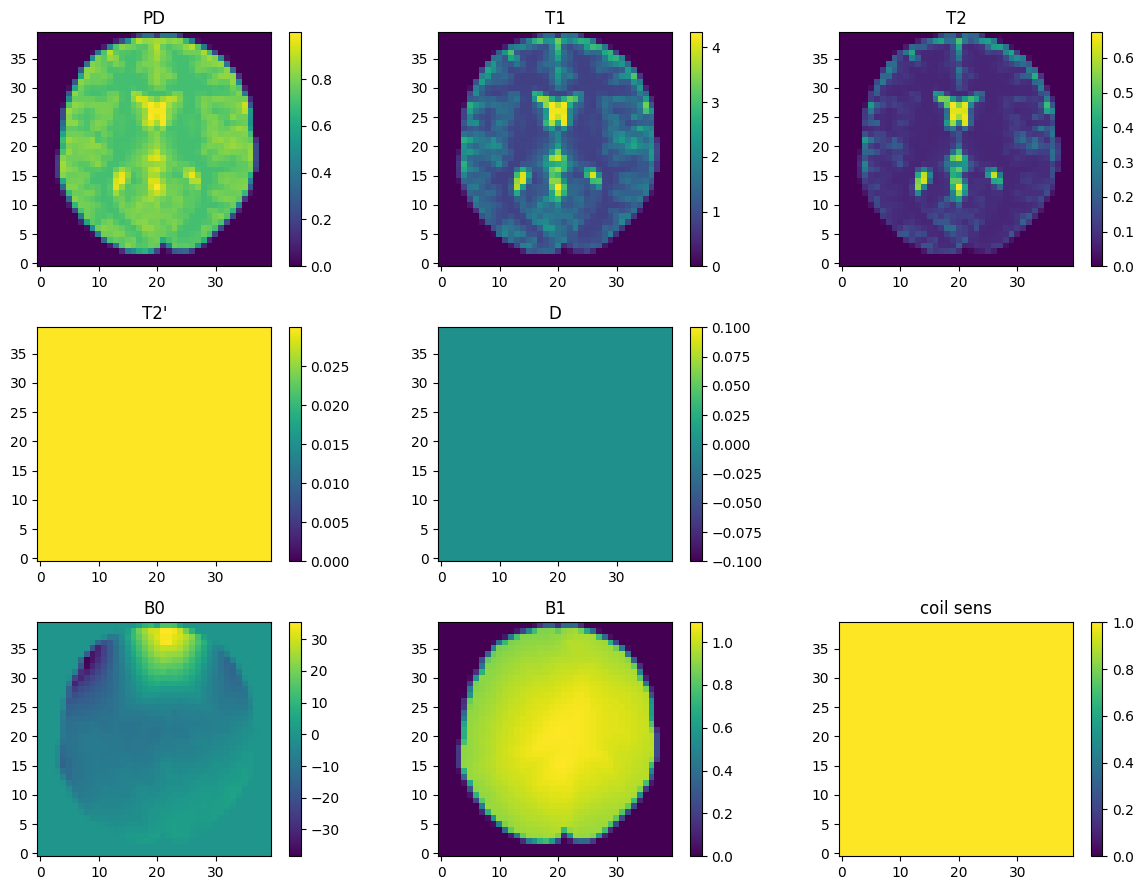

In [5]:
#@title 3D MSE in a 2D brain phantom - simulation
dB0 = 0
sz = [nRD, nPH, 1]
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
# (i) load a phantom object from file
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], sz[2])
# The default fov is loaded from the data, but we can change it:
obj_p.size = torch.tensor([0.15,0.15,0.15])
# Manipulate loaded data
obj_p.T2dash[:] = 30e-3
obj_p.D *= 0
obj_p.B0 *= 1    # alter the B0 inhomogeneity
# Store PD and B0 for comparison
PD = obj_p.PD
B0 = obj_p.B0
# Manipulate loaded data
obj_p.B0+=dB0
obj_p.D*=0
obj_p.plot()
# Convert Phantom into simulation data
obj_p=obj_p.build()

# %% SIMULATE  the external.seq file and add acquired signal to ADC plot
signal = []
for i in range(seq_idx):
    # Read in the sequence
    seq_name = "batch_%i" % (i+1)
    seq0 = mr0.Sequence.import_file(seq_name + '.seq')
    # Simulate the sequence
    graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
    temp = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)
    signal.append(temp)
signal = torch.cat(signal, dim=0)
# PLOT sequence with signal in the ADC subplot
# seq.plot(plot_now=False)
# mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
# plt.show()


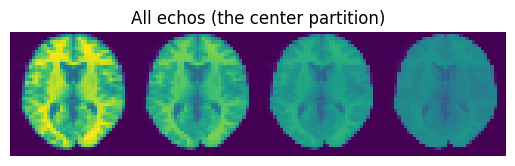

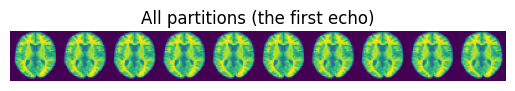

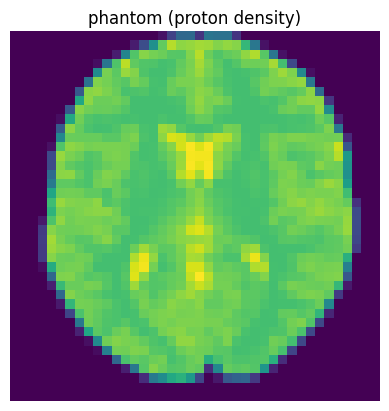

In [6]:
#@title 3D MSE for the portable scanner - reconstruction
# 3D FFT
def fft_3d(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x, axes=(0, 1, 3)), axes=(0, 1, 3)), axes=(0, 1, 3))

kspace = np.reshape(signal, (n3D, nPH, n_echo, os*(nRD+nRD_pre+nRD_post)))
kspace = kspace[:,:,:,os*(nRD_pre):os*(nRD_pre+nRD)]
im = fft_3d(kspace)
im = im[:,:,:,round(os*nRD/2-nRD/2):round(os*nRD/2+nRD/2)] # [partition, phase, echo, readout]

partition = 5 ; # the center partition
plt.figure()
plt.title('All echos (the center partition)')
plt.imshow(np.abs(im[partition,:,:,:].reshape(nPH,nRD*n_echo)), origin="lower"); plt.axis('off');

echo = 0 ; # the first echo
plt.figure()
plt.title('All partitions (the first echo)')
plt.imshow(np.abs(im[:,:,echo,:].squeeze().transpose([1,0,2]).reshape(nPH,nRD*n3D)), origin="lower"); plt.axis('off');

plt.figure()
plt.title('phantom (proton density)')
plt.imshow(PD.squeeze().T, origin="lower"); plt.axis('off');